# Adiabatically Assisted Variational Quantum Linear Solver

The Adiabatically Assisted Variational Quantum Linear Solver is implemented below. The three main parts to are:

1. The Problem Specification
2. The Adiabatic Ansatz
3. The Cost Function

The adiabatic ansatz in imported from the adiabatic_ansatze.py file. This Ansatz is special in that it can be partially randomly initialized, while still ensuring the entire ansatz is equivalent to Identity. 

The problem specification and cost function are implemented in separate cell blocks below, and are equivalent to the standard VQLS.

In [1]:
#imports
import random
from math import pi
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from scipy.optimize import minimize
import copy
import numpy as np
from qiskit import Aer, execute
from qiskit.visualization import plot_histogram

import adiabatic_ansatze #aavqls ansatz

## Specify the Problem

Specifying the problem involves giving the number of qubits, and giving the relevant linear system $A\vec{x} = \vec{b}$ to be solved.

$A$ is a $2^n \times 2^n$ matrix given as a linear combination of $k$ unitary matrices $A = \Sigma_i c_iA_i$. 

The values for $c_i$ are given in the coefficient list, $[c_0, ..., c_k]$.

The unitaries $A_i$, of size $2^n \times 2^n$, are given as controlled versions of their respective quantum gates, with the idx value in the original_create_state_A_i function corresponding to the coefficent in the coefficent list at that same idx value, $c_{idx}$.

The control bit is assumed to be qubit 0, while the $A_i$ is to take up the $n$ qubits from $[1, ..., n]$. See diagram below for clarity.

$\vec{b}$ is given as a quantum state $|b>$ which is implemented here as a unitary gate $U$ such that $|b> = U|0>$.

($A_i$ are implemented as controlled gates while $U$ is not controlled, as per the cost function)

This example problem gives $A = I + 0.2 \cdot X_1 Z_2 + 0.2 \cdot  X_1$ (Where $X_1$ denotes an $X$ gate applied to the 1st qubit, similarly for the rest. $I$ denotes the Identity matrix (size 8 x 8 in this example) )

In [2]:
n_qubits = 3
coefficients = [1, 0.2, 0.2]

def create_state_b(quantum_circuit, qubits):
    for i in qubits:
        quantum_circuit.h(i)
        
def create_state_b_dg(quantum_circuit, qubits):
    create_state_b(quantum_circuit, qubits)
    
def original_create_state_A_i(quantum_circuit, idx):#assumed 0 is hadamard test ancilla
    if(idx == 0):
        None
    if(idx == 1):
        quantum_circuit.cx(0,1)
        quantum_circuit.cz(0,2)
    if(idx == 2):
        quantum_circuit.cx(0,1)          
        
def original_create_state_A_i_dg(quantum_circuit, idx):
    original_create_state_A_i(quantum_circuit, idx)


Below the problem is adapted in order to introduce the adiabatic behaviour. 

The coefficients of the known ground state $H_0$ are created as H_0.
The coefficients of the known ground state $H_1$ are created as H_1.


In the create_state_A_i function, another unitary matrix is introduced into the linear sum $A = \Sigma_i c_iA_i$, at index 0. The rest of the unitaries are shifted down. 

In this case, the Identity matrix is added as the new first unitary matrix in the linear sum. The coefficients of this linear sum are adapted later on during thre adiabatic process.

The coefficients H_0 and H_1 describe how to create $H_0$ and $H_1$ as linear sums of the unitaries created in the function create_state_A_i.

In [3]:
# Below Adapt the problem to include the known ground state hamiltonian in beginning position
H_0 = copy.deepcopy(np.array([1] + [0 for i in range(len(coefficients))]))
H_1 = copy.deepcopy(np.array([0] + coefficients))

def create_state_A_i(quantum_circuit, idx):
    if(idx == 0):
        pass
    else:
        original_create_state_A_i(quantum_circuit, idx-1)
    
def create_state_A_i_dg(quantum_circuit, idx):
    create_state_A_i(quantum_circuit, idx)

## Specify the Cost Function

The cost function below is a local cost function for the VQLS, specified in,

Carlos Bravo-Prieto, et al. "Variational Quantum Linear Solver: A Hybrid Algorithm for Linear Systems" (2019) [arXiv:1909.05820]

(uncomment additional code in cost function and gradient function in order to handle complex valued linear systems. [Note the ansatz may also have to be adapted in order to include complex values])

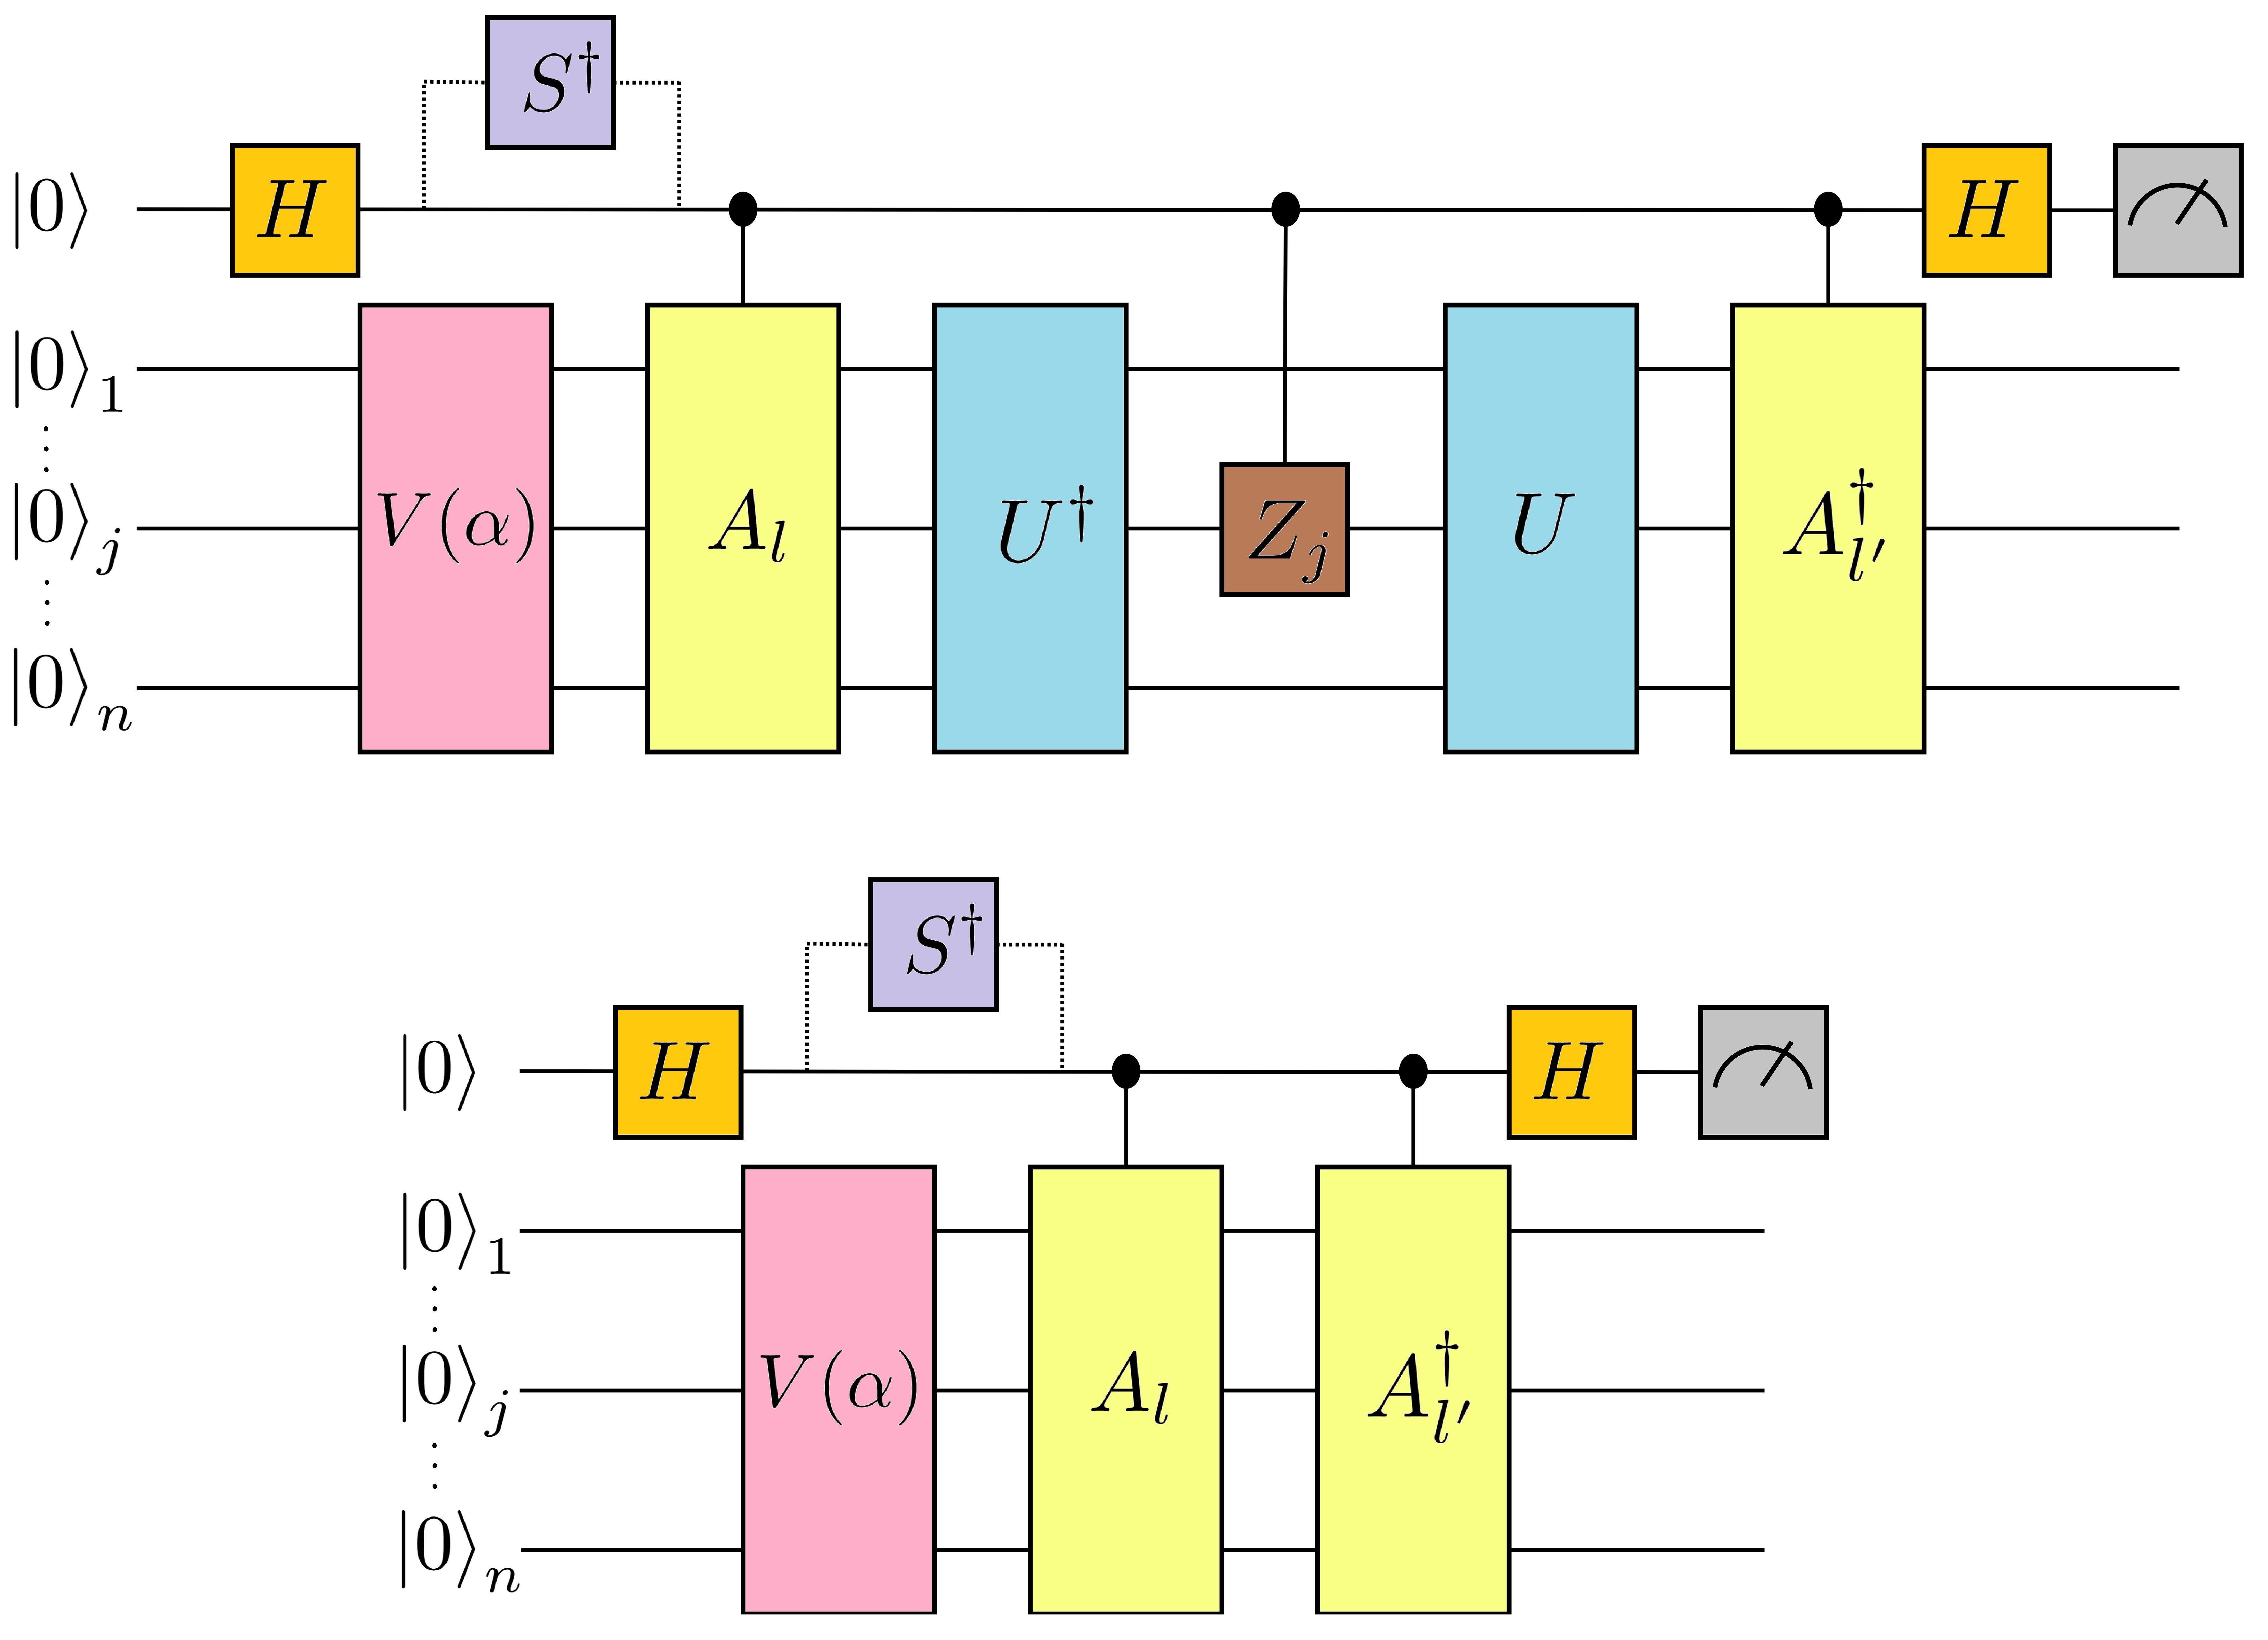

The numerator_hadamard_test function is responsible for creating and running the top hadamarrd test circuit, while the denominator_hadamard_test function is responsible for creating and running the bottom circuit.

Evaluation of the imaginary part in the cost function and gradient function have been commented out. These should be uncommented when a complex-valued linear system is evaluated. The ansatz may also need to be adapted in this case.

In [4]:
#specific to cost function
shots = 10000
noise_model = None
backend = None
coupling_map = None

def denominator_hadamard_test(ansatz, l, lp, part="Re"):
    had_test_circuit = QuantumCircuit(n_qubits+1,1) 
    had_test_circuit.h(0)

    if (part=="Im"):
        had_test_circuit.sdg(0)
    
    ansatz.create_ansatz_individual(had_test_circuit, [i+1 for i in range(n_qubits)])

    create_state_A_i(had_test_circuit, l)

    create_state_A_i_dg(had_test_circuit, lp)

    had_test_circuit.h(0)

    had_test_circuit.measure(0,0)
    job = execute(had_test_circuit, Aer.get_backend("qasm_simulator"), shots=shots, noise_model=noise_model)
    counts = job.result().get_counts()
    prob_0 = 0
    prob_1 = 0
    try:
        prob_0 = counts["0"]
        prob_1 = shots-prob_0
    except:
        prob_0 = 0
        prob_1 = shots       

    return (prob_0 - prob_1)/shots

def numerator_hadamard_test(ansatz, l, lp, j, part="Re"):
    had_test_circuit = QuantumCircuit(n_qubits+1,1)
    had_test_circuit.h(0)

    if (part=="Im"):
        had_test_circuit.sdg(0)

    ansatz.create_ansatz_individual(had_test_circuit, [i+1 for i in range(n_qubits)])

    create_state_A_i(had_test_circuit, l)

    create_state_b_dg(had_test_circuit, [i+1 for i in range(n_qubits)])

    had_test_circuit.cz(0, j)

    create_state_b(had_test_circuit, [i+1 for i in range(n_qubits)])
    
    create_state_A_i_dg(had_test_circuit, lp)
    
    had_test_circuit.h(0)

    
    had_test_circuit.measure(0,0)
    job = execute(had_test_circuit, Aer.get_backend("qasm_simulator"), shots=shots, noise_model=noise_model)
    counts = job.result().get_counts()
    prob_0 = 0
    prob_1 = 0
    try:
        prob_0 = counts["0"]
        prob_1 = shots-prob_0
    except:
        prob_0 = 0
        prob_1 = shots        

    return (prob_0 - prob_1)/shots

def cost_function(updated_ansatz_parameters, *args):
    ansatz = args[0]
    ansatz.update_parameters(updated_ansatz_parameters)  
    numerator_sum = 0.0
    denominator_sum = 0.0

    for l  in range(0, len(coefficients)):
        for lp in range(0, len(coefficients)):
            denominator_sum = denominator_sum + coefficients[l] * np.conj(coefficients[lp]) * denominator_hadamard_test(ansatz, l, lp, part="Re") #+ 1.0j * denominator_hadamard_test(ansatz, l, lp, part="Im")
            for j in range(1, n_qubits+1):        
                numerator_sum = numerator_sum + coefficients[l] * np.conj(coefficients[lp]) * numerator_hadamard_test(ansatz, l, lp, j, part="Re") #+ 1.0j * numerator_hadamard_test(ansatz, l, lp, j, part="Im")  
                

    x = 0.5 - 0.5 * numerator_sum / (n_qubits * denominator_sum)
    x = abs(x)
    print(x,end="\n")
    return x


def gradient(updated_ansatz_parameters, *args):
    ansatz = args[0]
    params = copy.deepcopy(updated_ansatz_parameters)
    numerator_sum = 0.0
    denominator_sum = 0.0
    gradient = []
    
    g = 0
    f = 0    
    
    ansatz.update_parameters(updated_ansatz_parameters)
    for l  in range(0, len(coefficients)):
        for lp in range(0, len(coefficients)):
            g = g + coefficients[l] * np.conj(coefficients[lp]) * denominator_hadamard_test(ansatz, l, lp, part="Re") #+ 1.0j * denominator_hadamard_test(ansatz, l, lp, part="Im")
            for j in range(1, n_qubits+1):        
                f = f + coefficients[l] * np.conj(coefficients[lp]) * numerator_hadamard_test(ansatz, l, lp, j, part="Re") #+ 1.0j * numerator_hadamard_test(ansatz, l, lp, j, part="Im")  
     
    
    for i in range(len(params)):
        postive_g = 0
        postive_f = 0
        negative_g = 0
        negative_f = 0
       
        positive_ansatz_parameters = copy.deepcopy(params)
        positive_ansatz_parameters[i] = positive_ansatz_parameters[i] + pi/2
        
        ansatz.update_parameters(positive_ansatz_parameters)
        
        for l  in range(0, len(coefficients)):
            for lp in range(0, len(coefficients)):
                postive_g = postive_g + coefficients[l] * np.conj(coefficients[lp]) * denominator_hadamard_test(ansatz, l, lp, part="Re") #+ 1.0j * denominator_hadamard_test(ansatz, l, lp, part="Im")
                for j in range(1, n_qubits+1):        
                    postive_f = postive_f + coefficients[l] * np.conj(coefficients[lp]) * numerator_hadamard_test(ansatz, l, lp, j, part="Re") #+ 1.0j * numerator_hadamard_test(ansatz, l, lp, j, part="Im") 
        
        
        negative_ansatz_parameters = copy.deepcopy(params)
        negative_ansatz_parameters[i] = negative_ansatz_parameters[i] - pi/2
                    
        ansatz.update_parameters(negative_ansatz_parameters)
        
        for l  in range(0, len(coefficients)):
            for lp in range(0, len(coefficients)):
                negative_g = negative_g + coefficients[l] * np.conj(coefficients[lp]) * denominator_hadamard_test(ansatz, l, lp, part="Re") #+ 1.0j * denominator_hadamard_test(ansatz, l, lp, part="Im")
                for j in range(1, n_qubits+1):        
                    negative_f = negative_f + coefficients[l] * np.conj(coefficients[lp]) * numerator_hadamard_test(ansatz, l, lp, j, part="Re") #+ 1.0j * numerator_hadamard_test(ansatz, l, lp, j, part="Im") 
              
        
        dg = 0.5 * (postive_g - negative_g) 
        df = 0.5 * (postive_f - negative_f) 

        dC = -1/(2*n_qubits) * (g * df - f * dg)/(g*g)
        
        if(dC < 0):
            dC = -abs(dC)
        else:
            dC = abs(dC)
            
        print(".", end="")
        gradient.append(dC)
        
    ansatz.update_parameters(updated_ansatz_parameters) 
    print()    
    return gradient 

## Running the AAVQLS

To run the AAVQLS, first an adiabatic ansatz object needs to be instantiated. In this case the Three_Ry_Ansatz
object from the adiabatic_ansatze.py file is selected. The instantiation is as follows

adiabatic_ansatze.Three_Ry_Ansatz(cost_function, optimization_method, optimization_options, 
                                  state_b = None, gradient_function=None, seed=None)
                               
| | | 
|-|-|
| cost_function| The cost_function function, found in the code block above. |
| optimization_method | An optimization method from scipy.optimize.minimize. |
| optimization_options | The optimization options dictionary of the above optimization_method , the same as options in scipy.optimize.minimize.|
| state_b | function to create state b on a quantum circuit, this is create_state_b above. |
| gradient_function | the gradient function for the cost function, if required. |
| seed | a seed for the random function. |


The AAVQLS runs in steps. The number of steps is sepcified in the steps variable. The step_size is calculated as 1/steps. 

The coefficients are then gradually adapted from the coefficents of the known ground state to the coefficents of the specific problem. 



In [5]:
optimization_method="BFGS"
optimization_options={'maxiter':20}
a = adiabatic_ansatze.Three_Ry_Ansatz(cost_function, optimization_method, optimization_options, state_b=create_state_b, gradient_function=gradient)

steps = 3
step_size = 1/steps

for t in range(1, steps+1):
    coefficients = copy.deepcopy((1 - t*step_size) * H_0 + (t*step_size) * H_1)
    print(coefficients)
    result = a.minimize()

[0.66666667 0.33333333 0.06666667 0.06666667]
0.0015851739944338084
.........
0.000537453882674066
.........
0.00020584163548104106
.........
0.0003049420913122658
.........
0.00023256077329225633
.........
0.0001685523710269754
.........
6.84852875393882e-05
.........
0.000544627427664035
.........
0.0006964554810925394
.........
0.0003355829527023624
.........
0.00026582405059905057
.........
0.0006310665896712697
.........
0.00010512201407963939
0.0001685976968948122
0.00015937244430647146
9.23369072991509e-05
0.00020180069530223443
0.0004650299825085247
0.00025738793070895216
8.75560675301923e-05
0.00019901458745275047
0.00037698000148106425
0.0006369867280792141
0.0002706062503577966
[0.33333333 0.66666667 0.13333333 0.13333333]
0.0016436925147577108
.........
3.730908408666744e-05
.........
0.0007601876177109612
.........
0.00020732869599826564
.........
0.00039621642353199205
.........
0.0010535010584827864
.........
8.713428495876752e-05
.........
7.724320425672726e-05
........

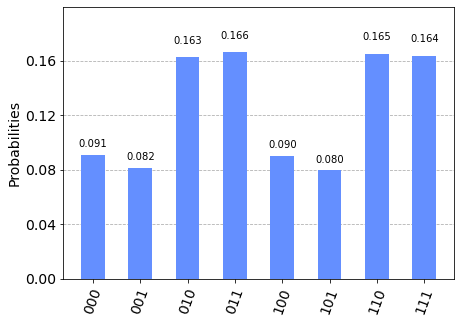

In [6]:
qc = QuantumCircuit(3)
a.create_ansatz_individual(qc, [0, 1, 2])
qc.measure_all()
job = execute(qc, Aer.get_backend("qasm_simulator"), shots=100000, noise_model=noise_model)
counts = job.result().get_counts()
plot_histogram(counts)